# Modelling - Vanilla Algorithms
Author: P.C.O. Maseland <br>
Date: 03 December 2021 <br>

In [1]:
# !!! RUN !!!
#Import packages/libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#Random forest packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

### Load Correct datafile

**prepared accelerometer, gyroscope and magnetometer csv**

In [2]:
# !!! RUN !!!
#local jupyter notebook path
path ="Totalset+slopes+mean+sd.csv"
df = pd.read_csv(path)

In [3]:
df.head(100)

,magnitude_chest_acc,magnitude_forearm_acc,magnitude_head_acc,magnitude_shin_acc,magnitude_thigh_acc,magnitude_upperarm_acc,magnitude_waist_acc,magnitude_chest_gyr,magnitude_forearm_gyr,magnitude_head_gyr,...,magnitude_head_mag_mean,magnitude_head_mag_sd,magnitude_shin_mag_mean,magnitude_shin_mag_sd,magnitude_thigh_mag_mean,magnitude_thigh_mag_sd,magnitude_upperarm_mag_mean,magnitude_upperarm_mag_sd,magnitude_waist_mag_mean,magnitude_waist_mag_sd
0,9.771236,9.787128,9.684595,10.100332,9.532843,10.154984,9.825808,0.038048,0.005705,0.069351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.803299,9.830025,9.652884,10.090979,9.538804,10.144928,9.820284,0.036161,0.009607,0.063729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.828618,9.848948,9.723963,10.092054,9.538612,10.162209,9.807764,0.037268,0.008487,0.067978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.672613,9.831390,9.775289,10.098940,9.530453,10.222147,9.857982,0.051724,0.008386,0.075489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.800911,9.879557,9.749285,10.089414,9.536494,10.269088,9.843884,0.050047,0.014337,0.092244,...,50.880480,0.000000e+00,39.744127,0.0,43.489173,0.000000,49.108764,0.0,49.129630,0.068392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.813382,9.843272,9.728845,10.123720,9.531407,10.199592,9.815353,0.074777,0.050545,0.062284,...,50.814043,1.935957e-01,39.966902,0.0,43.415478,0.134441,49.179638,0.0,49.233537,0.398488
96,9.758835,9.837921,9.746465,10.113368,9.523090,10.203853,9.887570,0.073352,0.051339,0.061273,...,50.896380,1.215304e-01,39.966902,0.0,43.355354,0.164656,49.179638,0.0,49.300787,0.332561
97,9.761502,9.849287,9.751139,10.105277,9.542320,10.198063,9.895177,0.069118,0.048489,0.064585,...,50.950730,1.795787e-07,39.966902,0.0,43.295230,0.164656,49.179638,0.0,49.298018,0.334056
98,9.816022,9.838173,9.704408,10.108862,9.533452,10.224991,9.815756,0.056011,0.047734,0.058587,...,50.950730,1.795787e-07,39.966902,0.0,43.235106,0.134441,49.179638,0.0,49.148624,0.000000


In [3]:
# !!! RUN !!!
#reorder such that labels are at the back
df = df[[c for c in df if c not in ['Subject ID','Activity']] 
       + ['Subject ID','Activity']]

**Activity coding**
- 'climbingdown' {0} 
- 'climbingup' {1} 
- 'jumping' {2} 
- 'lying' {3} 
- 'running' {4} 
- 'sitting' {5}
- 'standing' {6} 
- 'walking' {7}]

In [38]:
#Class distribution
pd.crosstab(index = df["Activity"],columns="count")

col_0,count
Activity,
0,602580
1,689232
2,103584
3,920304
4,989028
5,918312
6,909348
7,927276


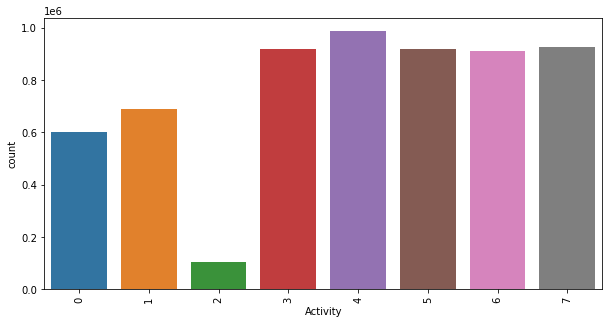

In [39]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Activity", data=df)
plt.xticks(x = df['Activity'],  rotation='vertical')
plt.show()

### Remove/Convert statistical NaN values
Since we calculated our rolled statistics over a nr of timesteps. The first nr of timesteps have a NaN, these are therefore useless. On the whole set we removed thereby 24336 rows, which is just a small fraction of 0.4% of the whole.

In [4]:
df.shape

(6084000, 86)

In [4]:
# !!! RUN !!!
df = df. dropna()

In [6]:
df.shape

(6059664, 86)

In [9]:
#removed rows. %loss
((6084000 - 6059664) /6084000)*100

0.4

### Full set copy

In [5]:
# !!! RUN !!!
#create copy full set
fullset = df
print(fullset.shape)

#drop subject ID
fullset_without_subject = fullset.drop(columns=['Subject ID'])

#shuffle fullset
fullset_without_subject = fullset_without_subject.sample(frac=1)

(6059664, 86)


In [6]:
# !!! RUN !!!
#take 10% of the data just for computational advantages, just experimenting
size_subset = 0.1
fullset_without_subject = fullset.drop(columns=['Subject ID'])

#shuffle fullset
fullset_without_subject = fullset_without_subject.sample(frac=1)
subset_without_subject = fullset_without_subject[0:round(len(df)*size_subset)]
print(subset_without_subject.shape)
print(type(subset_without_subject))

(605966, 85)
<class 'pandas.core.frame.DataFrame'>


In [7]:
#subset alternative (smaller set)
statistical_cols = [col for col in subset_without_subject.columns if ('mean' in col 
                                                                      or 'sd' in col
                                                                      or 'Activity' in col)]
statistical_cols

new_subset2 = subset_without_subject[statistical_cols]
new_subset2.shape

(605966, 43)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

### Make new subset
With only time-base statistical values

In [6]:
# !!! RUN !!!
statistical_cols = [col for col in fullset_without_subject.columns if ('mean' in col 
                                                                      or 'sd' in col
                                                                      or 'Activity' in col)]
new_subset = fullset_without_subject[statistical_cols]
new_subset.shape

(6059664, 43)

### Model Set up - Random Forest


#### best grid

In [8]:
# !!! RUN !!!
#with use of more then 2 features
best_grid = RandomForestClassifier(max_depth=32, 
                                   max_features=3, 
                                   min_samples_leaf=3, 
                                   min_samples_split=8, 
                                   n_estimators=50, #was 200
                                   class_weight='balanced')

In [9]:
# !!! RUN !!!
#with only max of 2 features
best_grid2 = RandomForestClassifier(max_depth=32, 
                                   max_features=2, 
                                   min_samples_leaf=3, 
                                   min_samples_split=8, 
                                   n_estimators=50, #geen verschil met 200
                                   class_weight='balanced')

### automated functions
* dataset_prep --> input dataset and filter, makes a subset
* rf_model_new --> runs a model on the subset prints conf matrix and performance stats

In [10]:
# !!! RUN !!!
def dataset_prep(dataset, filters):
    filterscolls = [col for col in dataset.columns if (filters in col or 'Activity' in col)]
    outputname = dataset[filterscolls]
    
    return outputname

In [11]:
# !!! RUN !!!
def rf_model_new(gridmodel, dataset):
    X = dataset.iloc[:,:-1]
    y = dataset['Activity']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    # Instantiate model 
    rf = gridmodel

    # Train the model on training data
    rf.fit(X_train, y_train)
    
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    y_pred_rnd = np.around(y_pred_test, 0)

    # Calculate the absolute errors
    errors = abs(y_pred_rnd - y_test)

    # Print out the mean absolute error (MAE)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    #Print out the mean squared error (MSE)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    print("Train mse: {} Test mse: {}".format(mse_train, mse_test))

    #Evaluating matrix
    print(confusion_matrix(y_test, y_pred_rnd))
    print(classification_report(y_test, y_pred_rnd))
    
    return rf, X#, y_pred_rnd, y_pred_train, y_train, y_test

## Single Sensor position - Subq 1
Slope score low on feature importance score

Positions: <br>
Head <br>
Upperarm <br>
Forearm <br>
Chest <br>
Waist <br>
Thigh <br>
Shin <br>

Different Sensors: <br>
acc (mean, sd) <br>
gyr (mean, sd) <br>
mag (mean, sd) <br>
acc + mag (mean, sd) <br>
acc + gyr (mean, sd) <br>
gyr + mag (mean, sd) <br>
acc + gyr + mag (mean, sd) <br>

#### Single sensor HEAD

In [30]:
#Single Head - acc
head_acc_subset = dataset_prep(new_subset, 'head_acc')
head_acc, head_acc_X = rf_model_new(best_grid, head_acc_subset)
#importance_features(head_acc, head_acc_X, 'head_acc')

(4847731, 2)
(4847731,)
(1211933, 2)
(1211933,)
Mean Absolute Error: 0.93 degrees.
Train mse: 1.1273243090427254 Test mse: 4.2997277902326285
[[ 76653  13707    175     81   6909    949   1458  20584]
 [ 13328  87818     16   1503   1502   4300   5724  23655]
 [    75     11  15458      0   5097      2      5     69]
 [   351   1132      0 141638    376  20398  19209    957]
 [  6265   3230   6829   3032 149561   9840  12628   6421]
 [   533   2596      1  22221    587 125497  30513   1714]
 [   761   3525      0  17246    615  27486 129757   2480]
 [ 19825  22488    119    122   5298   1347   2089 134167]]
              precision    recall  f1-score   support

           0       0.65      0.64      0.64    120516
           1       0.65      0.64      0.64    137846
           2       0.68      0.75      0.71     20717
           3       0.76      0.77      0.77    184061
           4       0.88      0.76      0.81    197806
           5       0.66      0.68      0.67    183662
      

In [31]:
#Single Head - gyr
head_gyr_subset = dataset_prep(new_subset, 'head_gyr')
head_gyr, head_gyr_X = rf_model_new(best_grid, head_gyr_subset)

(4847731, 2)
(4847731,)
(1211933, 2)
(1211933,)
Mean Absolute Error: 1.09 degrees.
Train mse: 1.2529102790563256 Test mse: 4.716396038394862
[[ 73626  10229   2181    314  14269   2144   3788  13965]
 [  9960  85941   1525   1124  11164   4759   6505  16868]
 [   832    500  14550     12   3572    104    207    940]
 [  1327   1958    149 151450   1155  13068  11921   3033]
 [ 13910  13469   5122   1811 129186   9102   8190  17016]
 [  6315   8121    974  15964   6097 115010  19260  11921]
 [  8249  11099   1164  11901   7573  24041 101501  16342]
 [ 14727  17759   2444    851  14011   4502   8925 122236]]
              precision    recall  f1-score   support

           0       0.57      0.61      0.59    120516
           1       0.58      0.62      0.60    137846
           2       0.52      0.70      0.60     20717
           3       0.83      0.82      0.82    184061
           4       0.69      0.65      0.67    197806
           5       0.67      0.63      0.65    183662
       

In [32]:
#Single Head - mag
head_mag_subset = dataset_prep(new_subset, 'head_mag')
head_mag, head_mag_X = rf_model_new(best_grid, head_mag_subset)

(4847731, 2)
(4847731,)
(1211933, 2)
(1211933,)
Mean Absolute Error: 0.98 degrees.
Train mse: 1.1150513508278408 Test mse: 4.1542791556959004
[[ 76964   8906   1996   2081  10748   4656   5936   9229]
 [  8717  89330   1934   3248  12831   5067   6242  10477]
 [   669    586  15544    426   1347    600    725    820]
 [  3956   4932   1292 157220   5085   2446   3864   5266]
 [ 11897  12853   3723   3299 128109   8812  12422  16691]
 [  6880   6683   2023   2414  11500 133820   9084  11258]
 [  8848   7995   2807   3019  15021   9179 121848  13153]
 [ 12708  14031   2818   3970  19074   8013  10543 114298]]
              precision    recall  f1-score   support

           0       0.59      0.64      0.61    120516
           1       0.61      0.65      0.63    137846
           2       0.48      0.75      0.59     20717
           3       0.89      0.85      0.87    184061
           4       0.63      0.65      0.64    197806
           5       0.78      0.73      0.75    183662
      

In [45]:
#Single Head - acc + gyr
filterscolls = [col for col in new_subset.columns if ('head_acc' in col 
                                                   or 'head_gyr' in col 
                                                   or 'Activity' in col)]
head_accgyr_subset = new_subset[filterscolls]    
head_accgyr, head_accgyr_X = rf_model_new(best_grid, head_accgyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.59 degrees.
Train mse: 0.4924670943994211 Test mse: 2.782492926589176
[[ 89465   8359     88     29   6220    665   1297  14393]
 [  8094 102195     17    416   1235   3701   5388  16800]
 [    61      7  16152      1   4453      1      8     34]
 [   366   1206      0 160246    101   9238  12257    647]
 [  4762   2645   3045   1099 161195   9483  11714   3863]
 [   266   1986      2   6158    237 152905  20846   1262]
 [   420   2506      0   5272    263  19145 152327   1937]
 [ 11041  13148     11     44   3189    914   2022 155086]]
              precision    recall  f1-score   support

           0       0.78      0.74      0.76    120516
           1       0.77      0.74      0.76    137846
           2       0.84      0.78      0.81     20717
           3       0.92      0.87      0.90    184061
           4       0.91      0.81      0.86    197806
           5       0.78      0.83      0.81    183662
       

In [19]:
#Single Head - acc + mag
filterscolls = [col for col in new_subset.columns if ('head_acc' in col 
                                                   or 'head_mag' in col 
                                                   or 'Activity' in col)]
head_accmag_subset = new_subset[filterscolls]  
head_accmag, head_accmag_X = rf_model_new(best_grid2, head_accmag_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.64 degrees.
Train mse: 1.1254209443552046 Test mse: 3.1546521136069403
[[ 81974  11115    119    143   5427    460   1334  19944]
 [  8662  99608      7    479   1389    951   2505  24245]
 [    58      9  17227      0   3366      1      7     49]
 [   332   1509      4 167613    159   5779   7956    709]
 [  3889   2887   3304   1075 160655   7796  13276   4924]
 [   347   1269      0   5241    292 150439  24698   1376]
 [   447   2008      2   5705    310  20184 150970   2244]
 [ 11944  14777     53     68   3129    838   2046 152600]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72    120516
           1       0.75      0.72      0.74    137846
           2       0.83      0.83      0.83     20717
           3       0.93      0.91      0.92    184061
           4       0.92      0.81      0.86    197806
           5       0.81      0.82      0.81    183662
      

In [20]:
#Single Head - gyr + mag
filterscolls = [col for col in new_subset.columns if ('head_mag' in col 
                                                   or 'head_gyr' in col 
                                                   or 'Activity' in col)]
head_maggyr_subset = new_subset[filterscolls] 
head_maggyr, head_maggyr_X = rf_model_new(best_grid2, head_maggyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.73 degrees.
Train mse: 0.8351127568753299 Test mse: 3.2469047381332135
[[ 81644   7503    931    222  12238   1357   3056  13565]
 [  5339  99529    571    507  10066   1557   3931  16346]
 [   481    161  16185     20   2606    181    282    801]
 [   991   1867    137 170418    878   3694   4143   1933]
 [  6120   8221   2068    917 150450   6452   6966  16612]
 [  3188   4569    548   3385   4793 144321  12334  10524]
 [  4602   6070    757   3288   7494  13700 131697  14262]
 [  7852  11404    889    577  12298   2838   6841 142756]]
              precision    recall  f1-score   support

           0       0.74      0.68      0.71    120516
           1       0.71      0.72      0.72    137846
           2       0.73      0.78      0.76     20717
           3       0.95      0.93      0.94    184061
           4       0.75      0.76      0.75    197806
           5       0.83      0.79      0.81    183662
      

In [21]:
#Single Head - acc + gyr + mag
filterscolls = [col for col in new_subset.columns if ('head_mag' in col
                                                      or 'head_gyr' in col
                                                      or 'head_acc' in col
                                                      or 'Activity' in col)]
head_accmaggyr_subset = new_subset[filterscolls] 
head_accmaggyr, head_accmaggyr_X = rf_model_new(best_grid, head_accmaggyr_subset)

(4847731, 6)
(4847731,)
(1211933, 6)
(1211933,)
Mean Absolute Error: 0.47 degrees.
Train mse: 0.7072735677784101 Test mse: 2.413732442304979
[[ 90015   8497    113     61   4817    292   1207  15514]
 [  6579 107615     13    195   1122    640   2137  19545]
 [    40      7  17778      0   2861      0      7     24]
 [   359   1341      3 174905    130   2581   4195    547]
 [  3450   2351   1976    654 171148   5684   9450   3093]
 [   225   1051      2   1515    381 162603  16650   1235]
 [   428   1664      1   1696    341  11346 164587   1807]
 [  8963  11370     15     29   1992    630   1810 160646]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78    120516
           1       0.80      0.78      0.79    137846
           2       0.89      0.86      0.88     20717
           3       0.98      0.95      0.96    184061
           4       0.94      0.87      0.90    197806
           5       0.88      0.89      0.89    183662
       

#### Single sensor UPPERARM

In [22]:
#create subsets for upperarm
upperarm_acc_subset = dataset_prep(new_subset, 'upperarm_acc')
upperarm_gyr_subset = dataset_prep(new_subset, 'upperarm_gyr')
upperarm_mag_subset = dataset_prep(new_subset, 'upperarm_mag')
filterscolls1 = [col for col in new_subset.columns if ('upperarm_acc' in col 
                                                   or 'upperarm_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('upperarm_acc' in col 
                                                   or 'upperarm_mag' in col 
                                                   or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('upperarm_mag' in col 
                                                   or 'upperarm_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('upperarm_mag' in col
                                                      or 'upperarm_gyr' in col
                                                      or 'upperarm_acc' in col
                                                      or 'Activity' in col)]
upperarm_accgyr_subset = new_subset[filterscolls1] 
upperarm_accmag_subset = new_subset[filterscolls2]
upperarm_maggyr_subset = new_subset[filterscolls3]
upperarm_accmaggyr_subset = new_subset[filterscolls4] 

In [23]:
#run all models for single sensor
upperarm_acc, upperarm_acc_X = rf_model_new(best_grid2, upperarm_acc_subset)
upperarm_gyr, upperarm_gyr_X = rf_model_new(best_grid2, upperarm_gyr_subset)
upperarm_mag, upperarm_mag_X = rf_model_new(best_grid2, upperarm_mag_subset)

(4847731, 2)
(4847731,)
(1211933, 2)
(1211933,)
Mean Absolute Error: 1.03 degrees.
Train mse: 2.5102182856268223 Test mse: 5.066362579449524
[[ 66085  14132    892    159  10504    649   1426  26669]
 [ 14669  72284    170    953   3561   5090   5361  35758]
 [   157     16  16743      0   3712      0      0     89]
 [   318   1551      2 171032    145   8734   1163   1116]
 [ 16488   7625   6451   1076 126708   6328  18750  14380]
 [   450   4078      1   8533    320 111346  56339   2595]
 [   448   4413      1   1280    312  17993 154358   3065]
 [ 20864  25341    453    366   7523   1220   2499 127189]]
              precision    recall  f1-score   support

           0       0.55      0.55      0.55    120516
           1       0.56      0.52      0.54    137846
           2       0.68      0.81      0.74     20717
           3       0.93      0.93      0.93    184061
           4       0.83      0.64      0.72    197806
           5       0.74      0.61      0.66    183662
       

In [24]:
#run all models for combination sensor
upperarm_accgyr, upperarm_accgyr_X = rf_model_new(best_grid, upperarm_accgyr_subset)
upperarm_accmag, upperarm_accmag_X = rf_model_new(best_grid, upperarm_accmag_subset)
upperarm_maggyr, upperarm_maggyr_X = rf_model_new(best_grid, upperarm_maggyr_subset)
upperarm_accmaggyr, upperarm_accmaggyr_X = rf_model_new(best_grid, upperarm_accmaggyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.68 degrees.
Train mse: 0.9916470200182312 Test mse: 3.365419540519154
[[ 81244   9821    975     24   6780    241    960  20471]
 [  8722  92680    120    380   3252   2868   3882  25942]
 [   169      4  18319      0   2192      0      1     32]
 [   207   1151      0 175342    202   5137   1170    852]
 [  7289   4098   3886    876 151003   5460  17780   7414]
 [   344   3031      5   5041    254 143955  28796   2236]
 [   284   3361      0    703    310  12776 161772   2664]
 [ 11139  16395    177     30   4992    372   1320 151030]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.71    120516
           1       0.71      0.67      0.69    137846
           2       0.78      0.88      0.83     20717
           3       0.96      0.95      0.96    184061
           4       0.89      0.76      0.82    197806
           5       0.84      0.78      0.81    183662
       

#### Single sensor FOREARM

In [25]:
#create subsets for forearm
forearm_acc_subset = dataset_prep(new_subset, 'forearm_acc')
forearm_gyr_subset = dataset_prep(new_subset, 'forearm_gyr')
forearm_mag_subset = dataset_prep(new_subset, 'forearm_mag')
filterscolls1 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                   or 'forearm_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                   or 'forearm_mag' in col 
                                                   or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('forearm_mag' in col 
                                                   or 'forearm_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('forearm_mag' in col
                                                      or 'forearm_gyr' in col
                                                      or 'forearm_acc' in col
                                                      or 'Activity' in col)]
forearm_accgyr_subset = new_subset[filterscolls1] 
forearm_accmag_subset = new_subset[filterscolls2]
forearm_maggyr_subset = new_subset[filterscolls3]
forearm_accmaggyr_subset = new_subset[filterscolls4] 

In [26]:
#run all models for single sensor
forearm_acc, forearm_acc_X = rf_model_new(best_grid2, forearm_acc_subset)
forearm_gyr, forearm_gyr_X = rf_model_new(best_grid2, forearm_gyr_subset)
forearm_mag, forearm_mag_X = rf_model_new(best_grid2, forearm_mag_subset)

(4847731, 2)
(4847731,)
(1211933, 2)
(1211933,)
Mean Absolute Error: 1.22 degrees.
Train mse: 2.767594158999334 Test mse: 5.654565062590094
[[ 62914  13871   1860    284  10298    533   1665  29091]
 [ 12430  70875    359   2740   3980   3443   5469  38550]
 [   395     47  15830      0   4293      0      3    149]
 [   472   1933      7 136907    331  19182  23524   1705]
 [ 15805   9706   6849   4757 122506   4924  13992  19267]
 [  1305   5282     48  27231    825 114306  29642   5023]
 [  1478   6462     82  28062    956  20450 118777   5603]
 [ 17568  23607    564    244   6389   1026   3267 132790]]
              precision    recall  f1-score   support

           0       0.56      0.52      0.54    120516
           1       0.54      0.51      0.53    137846
           2       0.62      0.76      0.68     20717
           3       0.68      0.74      0.71    184061
           4       0.82      0.62      0.71    197806
           5       0.70      0.62      0.66    183662
        

In [27]:
#run all models for combination sensor
forearm_accgyr, forearm_accgyr_X = rf_model_new(best_grid, forearm_accgyr_subset)
forearm_accmag, forearm_accmag_X = rf_model_new(best_grid, forearm_accmag_subset)
forearm_maggyr, forearm_maggyr_X = rf_model_new(best_grid, forearm_maggyr_subset)
forearm_accmaggyr, forearm_accmaggyr_X = rf_model_new(best_grid, forearm_accmaggyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.8 degrees.
Train mse: 1.2405935890419661 Test mse: 3.821839986203858
[[ 75177  10504   1376    147   9731    150    840  22591]
 [  7412  89503    334    889   3834   2269   3682  29923]
 [   392     23  17397      0   2801      0      5     99]
 [   225   1004      4 158360    210  13211  10181    866]
 [  8263   4476   3968   1348 151174   3851  16328   8398]
 [   639   2858     38  18177    590 138081  21207   2072]
 [   733   3544     54   8669    608  12467 153710   2085]
 [ 10430  16878    366     39   5046    293   1324 151079]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67    120516
           1       0.69      0.65      0.67    137846
           2       0.74      0.84      0.79     20717
           3       0.84      0.86      0.85    184061
           4       0.87      0.76      0.81    197806
           5       0.81      0.75      0.78    183662
        

#### Single sensor CHEST

In [39]:
#create subsets for Chest
Chest_acc_subset = dataset_prep(new_subset, 'chest_acc')
Chest_gyr_subset = dataset_prep(new_subset, 'chest_gyr')
Chest_mag_subset = dataset_prep(new_subset, 'chest_mag')
filterscolls1 = [col for col in new_subset.columns if ('chest_acc' in col 
                                                   or 'chest_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('chest_acc' in col 
                                                   or 'chest_mag' in col 
                                                   or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('chest_mag' in col 
                                                   or 'chest_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('chest_mag' in col
                                                      or 'chest_gyr' in col
                                                      or 'chest_acc' in col
                                                      or 'Activity' in col)]
Chest_accgyr_subset = new_subset[filterscolls1] 
Chest_accmag_subset = new_subset[filterscolls2]
Chest_maggyr_subset = new_subset[filterscolls3]
Chest_accmaggyr_subset = new_subset[filterscolls4] 

In [41]:
#run all models for single sensor
Chest_acc, Chest_acc_X = rf_model_new(best_grid2, Chest_acc_subset)
Chest_gyr, Chest_gyr_X = rf_model_new(best_grid2, Chest_gyr_subset)
Chest_mag, Chest_mag_X = rf_model_new(best_grid2, Chest_mag_subset)

(4847731, 2)
(4847731,)
(1211933, 2)
(1211933,)
Mean Absolute Error: 1.04 degrees.
Train mse: 2.449911721586862 Test mse: 5.01736894696324
[[ 61499  16485   1067    206  11000    278   1260  28721]
 [ 13410  74802    171   3352   4181   2372   3587  35971]
 [   208     19  15851      2   4554      0      5     78]
 [   196   1079      0 166615    212   8263   6816    880]
 [ 10706   5032   9360   1559 135975   6989  16367  11818]
 [   204   1574      0  15210    441 120133  44867   1233]
 [   364   2557      0  12392    499  34858 129062   2138]
 [ 18672  26781    741    379   9789    534   2216 126343]]
              precision    recall  f1-score   support

           0       0.58      0.51      0.54    120516
           1       0.58      0.54      0.56    137846
           2       0.58      0.77      0.66     20717
           3       0.83      0.91      0.87    184061
           4       0.82      0.69      0.75    197806
           5       0.69      0.65      0.67    183662
         

In [57]:
### run all models for combination sensor
Chest_accgyr, Chest_accgyr_X = rf_model_new(best_grid, Chest_accgyr_subset)
Chest_accmag, Chest_accmag_X = rf_model_new(best_grid, Chest_accmag_subset)
Chest_maggyr, Chest_maggyr_X = rf_model_new(best_grid, Chest_maggyr_subset)
Chest_accmaggyr, Chest_accmaggyr_X = rf_model_new(best_grid, Chest_accmaggyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.59 degrees.
Train mse: 0.9163064122163544 Test mse: 3.047146995749765
[[ 82485  10115   1532     10   3479    176    703  22016]
 [  8325 102167    152     51   1722    249   1575  23605]
 [   520     10  17539      1   2492      0      7    148]
 [   283    756      0 173337    274   4726   4142    543]
 [  2957   2380   3189    790 169501   5242  11065   2682]
 [   255    908      0   3980    482 150681  26152   1204]
 [   209   1752      0   3019    660  16891 157233   2106]
 [ 12480  14363    961     45   3109    383   1376 152738]]
              precision    recall  f1-score   support

           0       0.77      0.68      0.72    120516
           1       0.77      0.74      0.76    137846
           2       0.75      0.85      0.80     20717
           3       0.96      0.94      0.95    184061
           4       0.93      0.86      0.89    197806
           5       0.84      0.82      0.83    183662
       

#### Single sensor WAIST

In [43]:
#create subsets for Waist
Waist_acc_subset = dataset_prep(new_subset, 'waist_acc')
Waist_gyr_subset = dataset_prep(new_subset, 'waist_gyr')
Waist_mag_subset = dataset_prep(new_subset, 'waist_mag')
filterscolls1 = [col for col in new_subset.columns if ('waist_acc' in col 
                                                   or 'waist_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('waist_acc' in col 
                                                   or 'waist_mag' in col 
                                                   or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('waist_mag' in col 
                                                   or 'waist_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('waist_mag' in col
                                                      or 'waist_gyr' in col
                                                      or 'waist_acc' in col
                                                      or 'Activity' in col)]
Waist_accgyr_subset = new_subset[filterscolls1] 
Waist_accmag_subset = new_subset[filterscolls2]
Waist_maggyr_subset = new_subset[filterscolls3]
Waist_accmaggyr_subset = new_subset[filterscolls4] 

In [44]:
#run all models for single sensor
Waist_acc, Waist_acc_X = rf_model_new(best_grid2, Waist_acc_subset)
Waist_gyr, Waist_gyr_X = rf_model_new(best_grid2, Waist_gyr_subset)
Waist_mag, Waist_mag_X = rf_model_new(best_grid2, Waist_mag_subset)

(4847731, 2)
(4847731,)
(1211933, 2)
(1211933,)
Mean Absolute Error: 1.04 degrees.
Train mse: 2.1798589897005423 Test mse: 4.919554958896243
[[ 63050  16788   1603    199  13589    138   1134  24015]
 [ 13505  84594    338   1319   4432    335   3282  30041]
 [   407     73  15595      0   4344      0     15    283]
 [   258   2433      0 156884    351  13002  10358    775]
 [ 12373   6359   8466   1716 128620   3587  19867  16818]
 [   139   1090      1  21971    460 110737  48708    556]
 [   350   3654      3   6702    782  21371 147715   1293]
 [ 20618  29557   1045    195  10302    178   1914 121646]]
              precision    recall  f1-score   support

           0       0.57      0.52      0.55    120516
           1       0.59      0.61      0.60    137846
           2       0.58      0.75      0.65     20717
           3       0.83      0.85      0.84    184061
           4       0.79      0.65      0.71    197806
           5       0.74      0.60      0.67    183662
       

In [46]:
#run all models for combination sensor
Waist_accgyr, Waist_accgyr_X = rf_model_new(best_grid, Waist_accgyr_subset)
Waist_accmag, Waist_accmag_X = rf_model_new(best_grid, Waist_accmag_subset)
Waist_maggyr, Waist_maggyr_X = rf_model_new(best_grid, Waist_maggyr_subset)
Waist_accmaggyr, Waist_accmaggyr_X = rf_model_new(best_grid, Waist_accmaggyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.66 degrees.
Train mse: 0.8158519934377547 Test mse: 3.2039724968294454
[[ 78282  10791   1038     68  10308    116    495  19418]
 [  8038 100415    180    432   2825    178   1566  24212]
 [   469     26  17023      0   2954      2     14    229]
 [   229   1353      2 165787    233   8036   7821    600]
 [  5600   3004   3270   1376 159990   2803  17828   3935]
 [   118    798      0  11948    252 140335  29814    397]
 [   116   1797      2   4213    330  12771 161471   1170]
 [ 10835  17235    576     79   3892    124   1128 151586]]
              precision    recall  f1-score   support

           0       0.75      0.65      0.70    120516
           1       0.74      0.73      0.73    137846
           2       0.77      0.82      0.80     20717
           3       0.90      0.90      0.90    184061
           4       0.88      0.81      0.85    197806
           5       0.85      0.76      0.81    183662
      

#### Single sensor THIGH

In [47]:
#create subsets for Thigh
Thigh_acc_subset = dataset_prep(new_subset, 'thigh_acc')
Thigh_gyr_subset = dataset_prep(new_subset, 'thigh_gyr')
Thigh_mag_subset = dataset_prep(new_subset, 'thigh_mag')
filterscolls1 = [col for col in new_subset.columns if ('thigh_acc' in col 
                                                   or 'thigh_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('thigh_acc' in col 
                                                   or 'thigh_mag' in col 
                                                   or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('thigh_mag' in col 
                                                   or 'thigh_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('thigh_mag' in col
                                                      or 'thigh_gyr' in col
                                                      or 'thigh_acc' in col
                                                      or 'Activity' in col)]
Thigh_accgyr_subset = new_subset[filterscolls1] 
Thigh_accmag_subset = new_subset[filterscolls2]
Thigh_maggyr_subset = new_subset[filterscolls3]
Thigh_accmaggyr_subset = new_subset[filterscolls4] 

In [ ]:
###### run all models for single sensor
Thigh_acc, Thigh_acc_X = rf_model_new(best_grid2, Thigh_acc_subset)
Thigh_gyr, Thigh_gyr_X = rf_model_new(best_grid2, Thigh_gyr_subset)
Thigh_mag, Thigh_mag_X = rf_model_new(best_grid2, Thigh_mag_subset)

In [49]:
#run all models for combination sensor
Thigh_accgyr, Thigh_accgyr_X = rf_model_new(best_grid, Thigh_accgyr_subset)
Thigh_accmag, Thigh_accmag_X = rf_model_new(best_grid, Thigh_accmag_subset)
Thigh_maggyr, Thigh_maggyr_X = rf_model_new(best_grid, Thigh_maggyr_subset)
Thigh_accmaggyr, Thigh_accmaggyr_X = rf_model_new(best_grid, Thigh_accmaggyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.6 degrees.
Train mse: 0.6584814627709334 Test mse: 2.901685159163089
[[ 86215   9662   1615     22   8874     55    640  13433]
 [  9238 102202   1056    872   5350    704   2777  15647]
 [   505    169  17284      0   1965      3     26    765]
 [   154   1146      3 171207    362   5347   5596    246]
 [  7132   4359   2209    485 155178   1700  15877  10866]
 [   138   1020      0   5605    505 166956   9301    137]
 [   300   2235      0   2112    839   3319 172688    377]
 [ 12308  16894   1850     26  14264     45    716 139352]]
              precision    recall  f1-score   support

           0       0.74      0.72      0.73    120516
           1       0.74      0.74      0.74    137846
           2       0.72      0.83      0.77     20717
           3       0.95      0.93      0.94    184061
           4       0.83      0.78      0.81    197806
           5       0.94      0.91      0.92    183662
        

#### Single sensor SHIN

In [50]:
#create subsets for Shin
Shin_acc_subset = dataset_prep(new_subset, 'shin_acc')
Shin_gyr_subset = dataset_prep(new_subset, 'shin_gyr')
Shin_mag_subset = dataset_prep(new_subset, 'shin_mag')
filterscolls1 = [col for col in new_subset.columns if ('shin_acc' in col 
                                                   or 'shin_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('shin_acc' in col 
                                                   or 'shin_mag' in col 
                                                   or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('shin_mag' in col 
                                                   or 'shin_gyr' in col 
                                                   or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('shin_mag' in col
                                                      or 'shin_gyr' in col
                                                      or 'shin_acc' in col
                                                      or 'Activity' in col)]
Shin_accgyr_subset = new_subset[filterscolls1] 
Shin_accmag_subset = new_subset[filterscolls2]
Shin_maggyr_subset = new_subset[filterscolls3]
Shin_accmaggyr_subset = new_subset[filterscolls4] 

In [51]:
#run all models for single sensor
Shin_acc, Shin_acc_X = rf_model_new(best_grid2, Shin_acc_subset)
Shin_gyr, Shin_gyr_X = rf_model_new(best_grid2, Shin_gyr_subset)
Shin_mag, Shin_mag_X = rf_model_new(best_grid2, Shin_mag_subset)

(4847731, 2)
(4847731,)
(1211933, 2)
(1211933,)
Mean Absolute Error: 1.07 degrees.
Train mse: 1.921591977772694 Test mse: 4.794685019716437
[[ 74651  10515   3507    182  14320    593    595  16153]
 [ 17754  75755   3896   1581  13304   2480   3924  19152]
 [  1400    868  15117      0   2047      1      9   1275]
 [  1002   1792     14 147570    666  15278  16855    884]
 [ 19540  10516   4993   2267 120759   8290  12481  18960]
 [  2883   5985     47   4684   1037 128606  36324   4096]
 [  1097   3590      7   3822    838  31951 138454   2111]
 [ 26076  20086   5074    246  24854   1327   1449 106343]]
              precision    recall  f1-score   support

           0       0.52      0.62      0.56    120516
           1       0.59      0.55      0.57    137846
           2       0.46      0.73      0.57     20717
           3       0.92      0.80      0.86    184061
           4       0.68      0.61      0.64    197806
           5       0.68      0.70      0.69    183662
        

In [52]:
#run all models for combination sensor
Shin_accgyr, Shin_accgyr_X = rf_model_new(best_grid, Shin_accgyr_subset)
Shin_accmag, Shin_accmag_X = rf_model_new(best_grid, Shin_accmag_subset)
Shin_maggyr, Shin_maggyr_X = rf_model_new(best_grid, Shin_maggyr_subset)
Shin_accmaggyr, Shin_accmaggyr_X = rf_model_new(best_grid, Shin_accmaggyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.59 degrees.
Train mse: 0.828810014417054 Test mse: 2.7586227951545177
[[ 86786   7570   1559     35   7452    295    374  16445]
 [  8486 100339   2891   1248   5485   1273   2579  15545]
 [   950   1083  16626      0   1204      2     10    842]
 [   661   1375     25 168003    300   8176   5098    423]
 [  6797   4858   1563   1748 157090   6306  10652   8792]
 [  1255   3818      8   5371    686 150209  20710   1605]
 [   752   2629     22   3120    728  15370 158477    772]
 [ 10693   8527   1788     26  10771    279    283 153088]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.73    120516
           1       0.77      0.73      0.75    137846
           2       0.68      0.80      0.74     20717
           3       0.94      0.91      0.92    184061
           4       0.86      0.79      0.82    197806
           5       0.83      0.82      0.82    183662
       

## Combination (two sensor positions) - Subq 2
Logistic combination of sensor-positions
(head, waist, shin (scheenbeen), upperarm, forearm (onderarm), chest, thigh (pocket)) <br>

Head = smartglasses <br>
upperarm = smartphone (hardloopband) **Leave out**<br>
forearm = smartwatch <br>
thigh = pocket smartwatch <br>

Combinations: <br>
Head - Forearm <br>
Head - Upperarm **Leave out**<br>
Head - Thigh <br>
Forearm - Upperarm **Leave out**<br>
Forearm - Thigh <br>
Upperarm - Thigh **Leave out**<br>

Different Sensors: <br>
acc (mean, sd) <br>
gyr (mean, sd) <br>
mag (mean, sd) <br>
acc + mag (mean, sd) <br>
acc + gyr (mean, sd) <br>
gyr + mag (mean, sd) <br>
acc + gyr + mag (mean, sd) <br>

### Each combo - only acc

In [53]:
#create subsets for first combination
filterscolls1 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                   or 'head_acc' in col 
                                                   or 'Activity' in col)]

headforearm_acc_subset = new_subset[filterscolls1] 

In [54]:
#run all models for combination sensor
headforearm_acc, headforearm_acc_X = rf_model_new(best_grid, headforearm_acc_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.75 degrees.
Train mse: 1.2625469523783395 Test mse: 3.7205967656627883
[[ 79939  11417    148     56   5045    386    835  22690]
 [  9603  90560      3    943    774   3362   3771  28830]
 [    32      3  17229      0   3427      1      2     23]
 [   211    859      0 155088    168  12202  14937    596]
 [  4480   1980   3389   1703 160320   5783  16829   3322]
 [   178   1752      0   9209    216 145489  26192    626]
 [   254   2299      2   9908    293  16637 151620    857]
 [ 13342  19043     29     55   2359    414   1062 149151]]
              precision    recall  f1-score   support

           0       0.74      0.66      0.70    120516
           1       0.71      0.66      0.68    137846
           2       0.83      0.83      0.83     20717
           3       0.88      0.84      0.86    184061
           4       0.93      0.81      0.87    197806
           5       0.79      0.79      0.79    183662
      

In [55]:
#create subsets for first combinations with only acc
filterscolls1 = [col for col in new_subset.columns if ('upperarm_acc' in col 
                                                   or 'head_acc' in col 
                                                   or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('thigh_acc' in col 
                                                   or 'head_acc' in col 
                                                   or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('upperarm_acc' in col 
                                                   or 'forearm_acc' in col 
                                                   or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                   or 'thigh_acc' in col 
                                                   or 'Activity' in col)]
filterscolls5 = [col for col in new_subset.columns if ('upperarm_acc' in col 
                                                   or 'thigh_acc' in col 
                                                   or 'Activity' in col)]


headupperarm_acc_subset = new_subset[filterscolls1] 
headthigh_acc_subset = new_subset[filterscolls2] 
upperarmforearm_acc_subset = new_subset[filterscolls3] 
thighforearm_acc_subset = new_subset[filterscolls4] 
upperarmthigh_acc_subset = new_subset[filterscolls5]

In [56]:
#run all models for combination sensor
headupperarm_acc, headupperarm_acc_X = rf_model_new(best_grid, headupperarm_acc_subset)
headthigh_acc, headthigh_acc_X = rf_model_new(best_grid, headthigh_acc_subset)
upperarmforearm_acc, upperarmforearm_acc_X = rf_model_new(best_grid, upperarmforearm_acc_subset)
thighforearm_acc, thighforearm_acc_X = rf_model_new(best_grid, thighforearm_acc_subset)
upperarmthigh_acc, upperarmthigh_acc_X = rf_model_new(best_grid, upperarmthigh_acc_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.66 degrees.
Train mse: 1.3990623654654106 Test mse: 3.4047311196245995
[[ 79229  12356    207     34   4675    387    930  22698]
 [  9404  93644     47    577    540   3457   3667  26510]
 [    40      9  18114      0   2521      0      2     31]
 [   194    895      0 177100     82   3816   1325    649]
 [  4372   1831   2620    768 160134   6538  18540   3003]
 [   122   1736      1   4080    168 141270  35458    827]
 [   132   1670      0    981    190  15833 162079    985]
 [ 11946  20694     42     61   1241    430    997 150044]]
              precision    recall  f1-score   support

           0       0.75      0.66      0.70    120516
           1       0.70      0.68      0.69    137846
           2       0.86      0.87      0.87     20717
           3       0.96      0.96      0.96    184061
           4       0.94      0.81      0.87    197806
           5       0.82      0.77      0.80    183662
      

KeyboardInterrupt: 

### Each combo - only gyr

In [58]:
#create subsets for first combinations with only gyr
#filterscolls1 = [col for col in new_subset.columns if ('upperarm_gyr' in col 
                                                   #or 'head_gyr' in col 
                                                   #or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('thigh_gyr' in col 
                                                   or 'head_gyr' in col 
                                                   or 'Activity' in col)]
#filterscolls3 = [col for col in new_subset.columns if ('upperarm_gyr' in col 
                                                   #or 'forearm_gyr' in col 
                                                   #or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('forearm_gyr' in col 
                                                   or 'thigh_gyr' in col 
                                                   or 'Activity' in col)]
#filterscolls5 = [col for col in new_subset.columns if ('upperarm_gyr' in col 
                                                   #or 'thigh_gyr' in col 
                                                   #or 'Activity' in col)]
filterscolls6 = [col for col in new_subset.columns if ('forearm_gyr' in col 
                                                   or 'head_gyr' in col 
                                                   or 'Activity' in col)]

#headupperarm_gyr_subset = new_subset[filterscolls1] 
headthigh_gyr_subset = new_subset[filterscolls2] 
#upperarmforearm_gyr_subset = new_subset[filterscolls3] 
thighforearm_gyr_subset = new_subset[filterscolls4] 
#upperarmthigh_gyr_subset = new_subset[filterscolls5]
headforearm_gyr_subset = new_subset[filterscolls6] 

In [59]:
#run all models for combination sensor
#headupperarm_gyr, headupperarm_gyr_X = rf_model_new(best_grid, headupperarm_gyr_subset)
headthigh_gyr, headthigh_gyr_X = rf_model_new(best_grid, headthigh_gyr_subset)
#upperarmforearm_gyr, upperarmforearm_gyr_X = rf_model_new(best_grid, upperarmforearm_gyr_subset)
thighforearm_gyr, thighforearm_gyr_X = rf_model_new(best_grid, thighforearm_gyr_subset)
#upperarmthigh_gyr, upperarmthigh_gyr_X = rf_model_new(best_grid, upperarmthigh_gyr_subset)
headforearm__gyr, headforearm__gyr_X = rf_model_new(best_grid, headforearm_gyr_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.63 degrees.
Train mse: 0.6229322542855616 Test mse: 3.010732441479851
[[ 81413   9332   1723     29  10109    199    944  16767]
 [  6436 100302   1125    613   5239   2280   3050  18801]
 [  1097    524  15304      0   2524     33     52   1183]
 [   210    932     33 168326    297   5393   8648    222]
 [  5932   5242   2027    398 155828   4102  13856  10421]
 [   149    938     42   3631    719 158622  19308    253]
 [   577   2619    129   3512    898  11358 161556   1221]
 [  8921  15073   1331     26  11029    114    849 148112]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.72    120516
           1       0.74      0.73      0.74    137846
           2       0.70      0.74      0.72     20717
           3       0.95      0.91      0.93    184061
           4       0.83      0.79      0.81    197806
           5       0.87      0.86      0.87    183662
       

### Each combo - only mag

In [60]:
#create subsets for first combinations with only mag
#filterscolls1 = [col for col in new_subset.columns if ('upperarm_mag' in col 
#                                                   or 'head_mag' in col 
#                                                   or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('thigh_mag' in col 
                                                   or 'head_mag' in col 
                                                   or 'Activity' in col)]
#filterscolls3 = [col for col in new_subset.columns if ('upperarm_mag' in col 
#                                                   or 'forearm_mag' in col 
#                                                   or 'Activity' in col)]
filterscolls4 = [col for col in new_subset.columns if ('forearm_mag' in col 
                                                   or 'thigh_mag' in col 
                                                   or 'Activity' in col)]
#filterscolls5 = [col for col in new_subset.columns if ('upperarm_mag' in col 
#                                                   or 'thigh_mag' in col 
#                                                   or 'Activity' in col)]
filterscolls6 = [col for col in new_subset.columns if ('forearm_mag' in col 
                                                   or 'head_mag' in col 
                                                   or 'Activity' in col)]

#headupperarm_mag_subset = new_subset[filterscolls1] 
headthigh_mag_subset = new_subset[filterscolls2] 
#upperarmforearm_mag_subset = new_subset[filterscolls3] 
thighforearm_mag_subset = new_subset[filterscolls4] 
#upperarmthigh_mag_subset = new_subset[filterscolls5]
headforearm_mag_subset = new_subset[filterscolls6] 

In [61]:
#run all models for combination sensor
#headupperarm_mag, headupperarm_mag_X = rf_model_new(best_grid, headupperarm_mag_subset)
headthigh_mag, headthigh_mag_X = rf_model_new(best_grid, headthigh_mag_subset)
#upperarmforearm_mag, upperarmforearm_mag_X = rf_model_new(best_grid, upperarmforearm_mag_subset)
thighforearm_mag, thighforearm_mag_X = rf_model_new(best_grid, thighforearm_mag_subset)
#upperarmthigh_mag, upperarmthigh_mag_X = rf_model_new(best_grid, upperarmthigh_mag_subset)
headforearm__mag, headforearm__mag_X = rf_model_new(best_grid, headforearm_mag_subset)

(4847731, 4)
(4847731,)
(1211933, 4)
(1211933,)
Mean Absolute Error: 0.44 degrees.
Train mse: 0.6001325156036917 Test mse: 2.043423192536221
[[ 88213   5740   2089    245  13578    321   1470   8860]
 [  6440 106980   1674    183  10834    263   1057  10415]
 [   448     93  17734     27   1557     46    279    533]
 [   614    217    157 180731    893    212    647    590]
 [  6295   1992   3556    485 168995   1739   3667  11077]
 [   386    227    212    175   1480 177534   2833    815]
 [  1025    220    741    632   2684   2153 173497    918]
 [  8059   5756   2415    376  18516    609   1786 147938]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76    120516
           1       0.88      0.78      0.83    137846
           2       0.62      0.86      0.72     20717
           3       0.99      0.98      0.99    184061
           4       0.77      0.85      0.81    197806
           5       0.97      0.97      0.97    183662
       

### Each combo - only acc + gyr

In [62]:
#create subsets for first combinations with only acc+gyr
filterscolls1 = [col for col in new_subset.columns if ('thigh_acc' in col 
                                                       or 'thigh_gyr' in col
                                                       or 'head_acc' in col
                                                       or 'head_gyr' in col
                                                       or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                       or 'thigh_gyr' in col
                                                       or 'thigh_acc' in col
                                                       or 'forearm_gyr' in col 
                                                       or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                       or 'head_acc' in col
                                                       or 'head_gyr' in col
                                                       or 'forearm_gyr' in col
                                                       or 'Activity' in col)]
 
headthigh_accgyr_subset = new_subset[filterscolls1] 
thighforearm_accgyr_subset = new_subset[filterscolls2] 
headforearm_accgyr_subset = new_subset[filterscolls3] 

In [63]:
#run all models for combination sensor
headthigh_accgyr, headthigh_accgyr_X = rf_model_new(best_grid, headthigh_accgyr_subset)
thighforearm_accgyr, thighforearm_accgyr_X = rf_model_new(best_grid, thighforearm_accgyr_subset)
headforearm__accgyr, headforearm__accgyr_X = rf_model_new(best_grid, headforearm_accgyr_subset)

(4847731, 8)
(4847731,)
(1211933, 8)
(1211933,)
Mean Absolute Error: 0.36 degrees.
Train mse: 0.4191794057879862 Test mse: 1.912749302147891
[[ 95642   8715    223     13   3370     31    498  12024]
 [  6883 113765      8     72    641    491   2140  13846]
 [    62      4  18927      1   1702      0      8     13]
 [   126    949      0 177895    154   1379   3468     90]
 [  2624   1674   1422     97 177935   1261  11373   1420]
 [    42    686      0    600    390 175115   6755     74]
 [    53    958      0    507    541   2171 177472    168]
 [  8038  12014     28      6   1794     20    528 163027]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.82    120516
           1       0.82      0.83      0.82    137846
           2       0.92      0.91      0.92     20717
           3       0.99      0.97      0.98    184061
           4       0.95      0.90      0.93    197806
           5       0.97      0.95      0.96    183662
       

### Each combo - only acc + mag

In [64]:
#create subsets for first combinations with only acc+mag
filterscolls1 = [col for col in new_subset.columns if ('thigh_acc' in col 
                                                       or 'thigh_mag' in col
                                                       or 'head_acc' in col
                                                       or 'head_mag' in col
                                                       or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                       or 'thigh_mag' in col
                                                       or 'thigh_acc' in col
                                                       or 'forearm_mag' in col 
                                                       or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                       or 'head_acc' in col
                                                       or 'head_mag' in col
                                                       or 'forearm_mag' in col
                                                       or 'Activity' in col)]
 
headthigh_accmag_subset = new_subset[filterscolls1] 
thighforearm_accmag_subset = new_subset[filterscolls2] 
headforearm_accmag_subset = new_subset[filterscolls3] 

In [65]:
#run all models for combination sensor
headthigh_accmag, headthigh_accmag_X = rf_model_new(best_grid, headthigh_accmag_subset)
thighforearm_accmag, thighforearm_accmag_X = rf_model_new(best_grid, thighforearm_accmag_subset)
headforearm__accmag, headforearm__accmag_X = rf_model_new(best_grid, headforearm_accmag_subset)

(4847731, 8)
(4847731,)
(1211933, 8)
(1211933,)
Mean Absolute Error: 0.23 degrees.
Train mse: 0.4848245498770456 Test mse: 1.2556997787831505
[[104808   4925     77      5   2498      5    155   8043]
 [  8135 118663     15      4    411     20    182  10416]
 [    33      1  19272      0   1383      0     11     17]
 [   284    502      0 181865    328    123    660    299]
 [  2461    637    823     74 188530    312   3654   1315]
 [    69    222      0     22    296 181467   1358    228]
 [    97    234      0    103    634    506 180154    142]
 [  8177   4272     17      5   1208     26    113 171637]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86    120516
           1       0.92      0.86      0.89    137846
           2       0.95      0.93      0.94     20717
           3       1.00      0.99      0.99    184061
           4       0.97      0.95      0.96    197806
           5       0.99      0.99      0.99    183662
      

### Each combo - only gyr + mag

In [66]:
#create subsets for first combinations with only gyr+mag
filterscolls1 = [col for col in new_subset.columns if ('thigh_mag' in col 
                                                       or 'thigh_gyr' in col
                                                       or 'head_mag' in col
                                                       or 'head_gyr' in col
                                                       or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('forearm_mag' in col 
                                                       or 'thigh_gyr' in col
                                                       or 'thigh_mag' in col
                                                       or 'forearm_gyr' in col 
                                                       or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('forearm_mag' in col 
                                                       or 'head_mag' in col
                                                       or 'head_gyr' in col
                                                       or 'forearm_gyr' in col
                                                       or 'Activity' in col)]
 
headthigh_gyrmag_subset = new_subset[filterscolls1] 
thighforearm_gyrmag_subset = new_subset[filterscolls2] 
headforearm_gyrmag_subset = new_subset[filterscolls3] 

In [68]:
#run all models for combination sensor
headthigh_gyrmag, headthigh_gyrmag_X = rf_model_new(best_grid, headthigh_gyrmag_subset)
thighforearm_gyrmag, thighforearm_gyrmag_X = rf_model_new(best_grid, thighforearm_gyrmag_subset)
headforearm__gyrmag, headforearm__gyrmag_X = rf_model_new(best_grid, headforearm_gyrmag_subset)

(4847731, 8)
(4847731,)
(1211933, 8)
(1211933,)
Mean Absolute Error: 0.25 degrees.
Train mse: 0.3241066800117416 Test mse: 1.3003276583771546
[[101733   3843   1329      4   5143      5    203   8256]
 [  4909 120015    597     23   2207     34    270   9791]
 [   576     60  18649      0   1004      5     52    371]
 [   365    375     44 182327    256    127    332    235]
 [  3396    967   1401     50 185372    684   2301   3635]
 [   174    229     13     74    378 180511   1986    297]
 [   533    226    149     54    442    764 179243    459]
 [  6320   3645    924      3   4440     44    188 169891]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85    120516
           1       0.93      0.87      0.90    137846
           2       0.81      0.90      0.85     20717
           3       1.00      0.99      0.99    184061
           4       0.93      0.94      0.93    197806
           5       0.99      0.98      0.99    183662
      

### Each combo - only acc + gyr + mag

In [69]:
#create subsets for first combinations with only acc+gyr+mag
filterscolls1 = [col for col in new_subset.columns if ('thigh_acc' in col 
                                                       or 'thigh_gyr' in col
                                                       or 'head_acc' in col
                                                       or 'head_gyr' in col
                                                       or 'thigh_mag' in col
                                                       or 'head_mag' in col
                                                       or 'Activity' in col)]
filterscolls2 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                       or 'thigh_gyr' in col
                                                       or 'thigh_acc' in col
                                                       or 'forearm_gyr' in col
                                                       or 'thigh_mag' in col
                                                       or 'forearm_mag' in col
                                                       or 'Activity' in col)]
filterscolls3 = [col for col in new_subset.columns if ('forearm_acc' in col 
                                                       or 'head_acc' in col
                                                       or 'head_gyr' in col
                                                       or 'forearm_gyr' in col
                                                       or 'head_mag' in col
                                                       or 'forearm_mag' in col
                                                       or 'Activity' in col)]
 
headthigh_accgyrmag_subset = new_subset[filterscolls1] 
thighforearm_accgyrmag_subset = new_subset[filterscolls2] 
headforearm_accgyrmag_subset = new_subset[filterscolls3] 

In [70]:
#run all models for combination sensor
headthigh_accgyrmag, headthigh_accgyrmag_X = rf_model_new(best_grid, headthigh_accgyrmag_subset)
thighforearm_accgyrmag, thighforearm_accgyrmag_X = rf_model_new(best_grid, thighforearm_accgyrmag_subset)
headforearm__accgyrmag, headforearm__accgyrmag_X = rf_model_new(best_grid, headforearm_accgyrmag_subset)

(4847731, 12)
(4847731,)
(1211933, 12)
(1211933,)
Mean Absolute Error: 0.17 degrees.
Train mse: 0.3395854679230345 Test mse: 0.9851460435519125
[[108064   3606     96      1   1754      1    158   6836]
 [  4972 123315      6      4    280      8    153   9108]
 [    34      2  19819      0    843      0     10      9]
 [   256    484      0 182438    236     41    414    192]
 [  1729    521    433      9 191426    183   2506    999]
 [    63    275      0      3    199 181939    995    188]
 [   112    215      0      9    212    157 180980    185]
 [  5747   2919     15      6    805     26     93 175844]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89    120516
           1       0.94      0.89      0.92    137846
           2       0.97      0.96      0.96     20717
           3       1.00      0.99      1.00    184061
           4       0.98      0.97      0.97    197806
           5       1.00      0.99      0.99    183662
    

## Difference between Nr positions - Subq 3
We have looked into single and double positions, what about third positions <br>

Only combine top 3 positions from SQ1 that show promising results. or reflect on SQ combinations. 

Head = smartglasses <br>
forearm = smartwatch <br>
thigh = pocket smartwatch <br>

Combinations: <br>
Head - Forearm - Thigh <br>


Different Sensors: <br>
acc (mean, sd) <br>
gyr (mean, sd) <br>
mag (mean, sd) <br>
acc + mag (mean, sd) <br>
acc + gyr (mean, sd) <br>
gyr + mag (mean, sd) <br>
acc + gyr + mag (mean, sd) <br>

In [14]:
#create subsets for combinations with only head-forearm-thigh
#only acc
filterscolls1 = [col for col in new_subset.columns if ('thigh_acc' in col 
                                                       or 'head_acc' in col
                                                       or 'forearm_acc' in col
                                                       or 'Activity' in col)]
#only gyr
filterscolls2 = [col for col in new_subset.columns if ('thigh_gyr' in col
                                                       or 'head_gyr' in col
                                                       or 'forearm_gyr' in col
                                                       or 'Activity' in col)]
#only mag
filterscolls3 = [col for col in new_subset.columns if ('thigh_mag' in col
                                                       or 'head_mag' in col
                                                       or 'forearm_mag' in col
                                                       or 'Activity' in col)]
#acc+gyr
filterscolls4 = [col for col in new_subset.columns if ('thigh_acc' in col
                                                       or 'head_acc' in col
                                                       or 'forearm_acc' in col
                                                       or 'thigh_gyr' in col
                                                       or 'head_gyr' in col
                                                       or 'forearm_gyr' in col
                                                       or 'Activity' in col)]
#acc+mag
filterscolls5 = [col for col in new_subset.columns if ('thigh_acc' in col
                                                       or 'head_acc' in col
                                                       or 'forearm_acc' in col
                                                       or 'thigh_mag' in col
                                                       or 'head_mag' in col
                                                       or 'forearm_mag' in col
                                                       or 'Activity' in col)]
#gyr+mag
filterscolls6 = [col for col in new_subset.columns if ('thigh_gyr' in col
                                                       or 'head_gyr' in col
                                                       or 'forearm_gyr' in col
                                                       or 'thigh_mag' in col
                                                       or 'head_mag' in col
                                                       or 'forearm_mag' in col
                                                       or 'Activity' in col)]
#acc+gyr+mag
filterscolls7 = [col for col in new_subset.columns if ('thigh_acc' in col
                                                       or 'head_acc' in col
                                                       or 'forearm_acc' in col
                                                       or 'thigh_gyr' in col
                                                       or 'head_gyr' in col
                                                       or 'forearm_gyr' in col
                                                       or 'thigh_mag' in col
                                                       or 'head_mag' in col
                                                       or 'forearm_mag' in col
                                                       or 'Activity' in col)]
 
thighheadforearm_acc_subset = new_subset[filterscolls1] 
thighheadforearm_gyr_subset = new_subset[filterscolls2] 
thighheadforearm_mag_subset = new_subset[filterscolls3] 
thighheadforearm_accgyr_subset = new_subset[filterscolls4] 
thighheadforearm_accmag_subset = new_subset[filterscolls5] 
thighheadforearm_gyrmag_subset = new_subset[filterscolls6]
thighheadforearm_accgyrmag_subset = new_subset[filterscolls7]

In [15]:
#run all models for combination sensor only acc, gyr, mag
thighheadforearm_acc, thighheadforearm_acc_X = rf_model_new(best_grid, thighheadforearm_acc_subset)

(4847731, 6)
(4847731,)
(1211933, 6)
(1211933,)
Mean Absolute Error: 0.54 degrees.
Train mse: 0.9260421009334058 Test mse: 2.849374511627293
[[ 87482  11300     97      6   3858     48    603  17122]
 [  8860 101781      3    374    594   1228   2643  22363]
 [    38     11  18206      0   2455      1      0      6]
 [   123   1094      0 171794    153   3674   6938    285]
 [  3156   1716   1978    561 169641   1841  16855   2058]
 [    53    930      0   2710    308 167904  11679     78]
 [    52   1042      0   2228    450   3931 174093     74]
 [ 11264  19164      5     17   1720     53    675 152557]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76    120516
           1       0.74      0.74      0.74    137846
           2       0.90      0.88      0.89     20717
           3       0.97      0.93      0.95    184061
           4       0.95      0.86      0.90    197806
           5       0.94      0.91      0.93    183662
       

In [16]:
thighheadforearm_gyr, thighheadforearm_gyr_X = rf_model_new(best_grid, thighheadforearm_gyr_subset)
thighheadforearm_mag, thighheadforearm_mag_X = rf_model_new(best_grid, thighheadforearm_mag_subset)

(4847731, 6)
(4847731,)
(1211933, 6)
(1211933,)
Mean Absolute Error: 0.52 degrees.
Train mse: 0.4503758562510997 Test mse: 2.5166160175521255
[[ 86933   8190   1673     21   8202    198    637  14662]
 [  5229 106679    923    401   3429   1656   2172  17357]
 [  1238    433  16026      0   1869     11     24   1116]
 [   156    826     29 172476    217   4635   5571    151]
 [  5008   3021   1611    200 164889   3274  12208   7595]
 [    97    740     15   2769    501 164427  14952    161]
 [   324   1485     51   2055    705   8047 168619    584]
 [  7442  13173   1412     17   7192    101    653 155465]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77    120516
           1       0.79      0.77      0.78    137846
           2       0.74      0.77      0.75     20717
           3       0.97      0.94      0.95    184061
           4       0.88      0.83      0.86    197806
           5       0.90      0.90      0.90    183662
      

In [17]:
#run all models for combination sensor only acc+gyr, acc+mag, gyr+mag
thighheadforearm_accgyr, thighheadforearm_accgyr_X = rf_model_new(best_grid, thighheadforearm_accgyr_subset)
thighheadforearm_accmag, thighheadforearm_accmag_X = rf_model_new(best_grid, thighheadforearm_accmag_subset)
thighheadforearm_gyrmag, thighheadforearm_gyrmag_X = rf_model_new(best_grid, thighheadforearm_gyrmag_subset)

(4847731, 12)
(4847731,)
(1211933, 12)
(1211933,)
Mean Absolute Error: 0.36 degrees.
Train mse: 0.6828404876425693 Test mse: 1.9814766987944052
[[ 95017   9090    139      5   2591     25    466  13183]
 [  5484 112882      8     45    348    322   1411  17346]
 [    54      6  19413      0   1237      1      2      4]
 [    94    795      0 180107    130    697   2160     78]
 [  1921   1135    758     40 182916    849   9360    827]
 [    34    476      0    167    202 177487   5241     55]
 [    28    502      0    163    298   1120 179681     78]
 [  6768  14396      1      9    855     10    513 162903]]
              precision    recall  f1-score   support

           0       0.87      0.79      0.83    120516
           1       0.81      0.82      0.81    137846
           2       0.96      0.94      0.95     20717
           3       1.00      0.98      0.99    184061
           4       0.97      0.92      0.95    197806
           5       0.98      0.97      0.97    183662
    

In [ ]:
#run all models for combination sensor only acc+gyr, acc+mag, gyr+mag
thighheadforearm_accgyrmag, thighheadforearm_accgyrmag_X = rf_model_new(best_grid, thighheadforearm_accgyrmag_subset)

(4847731, 18)
(4847731,)
(1211933, 18)
(1211933,)
